In [41]:
import os
import io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from torchvision import transforms
from torchvision.transforms import Lambda
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from google.cloud import storage
from PIL import Image, ImageDraw
import pandas as pd

# Set environment variables
os.environ["GCLOUD_PROJECT"] = "rhd-diagnosis"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "rhd-diagnosis-17affaa34749.json"

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import torchvision components after setting environment variables
from torchvision import transforms, models
import torchvision.transforms.functional as F

class GCPBucketDataset(Dataset):
    def __init__(self, bucket_name, prefix, csv_file, transform=None):
        self.bucket_name = bucket_name
        self.prefix = prefix
        self.transform = transform  # Corrected to use the passed transform

        # Connect to Google Cloud Storage
        self.storage_client = storage.Client()
        self.bucket = self.storage_client.bucket(self.bucket_name)

        # Get list of files in the bucket
        self.file_paths = [blob.name for blob in self.bucket.list_blobs(prefix=self.prefix)]

        # Read labels from CSV file
        self.labels, self.num_classes = self._read_labels(csv_file)

    def _read_labels(self, csv_file):
        # Download the CSV file from the bucket
        blob = self.bucket.blob(csv_file)
        with blob.open("rb") as f:
            labels_df = pd.read_csv(f)
        
        # Convert to dictionary for quick lookup
        # Clean up condition labels by removing extra brackets
        labels_df['CONDITION'] = labels_df['CONDITION'].str.strip("[]").str.replace("'", "")

        labels_dict = dict(zip(labels_df['FILENAME'], 
                               zip(labels_df['VIEW-APP'], 
                                   labels_df['CONDITION'], 
                                   labels_df['SEVERITY'])))
        
        # Count unique classes
        num_classes = {
            'view': len(labels_df['VIEW-APP'].unique()),
            'condition': len(labels_df['CONDITION'].unique()),
            'severity': len(labels_df['SEVERITY'].unique())
        }
        
        # Print the number of unique classes
        print("Number of unique classes:")
        print(num_classes)

        # Print the actual unique values
        unique_values = {
            'view': labels_df['VIEW-APP'].unique(),
            'condition': labels_df['CONDITION'].unique(),
            'severity': labels_df['SEVERITY'].unique()
        }
        
        print("\nUnique values for each label type:")
        for label_type, values in unique_values.items():
            print(f"{label_type.capitalize()} labels: {values}")
        
        return labels_dict, num_classes

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        blob = self.bucket.blob(file_path)

        try:
            # Download the file from the bucket
            with blob.open("rb") as f:
                image = Image.open(io.BytesIO(f.read())).convert('RGB')
        except Exception as e:
            print(f"Error loading image {file_path}: {e}")
            # Return a tensor of zeros if image loading fails
            return torch.zeros(3, 224, 224), torch.zeros(3, 224, 224), (-1, -1, -1)

        # Apply transformations to get two views
        if self.transform:
            x_i = self.transform(image)
            x_j = self.transform(image)
        else:
            x_i = transforms.ToTensor()(image)
            x_j = transforms.ToTensor()(image)

        # Verify tensor shapes
        assert x_i.shape == torch.Size([3, 224, 224]), f"x_i shape mismatch: {x_i.shape}"
        assert x_j.shape == torch.Size([3, 224, 224]), f"x_j shape mismatch: {x_j.shape}"

        # Extract the filename from the file path
        filename = os.path.basename(file_path)

        # Get the labels for the image
        view_label, condition_label, severity_label = self.labels.get(filename, (-1, -1, -1))

        return x_i, x_j, (view_label, condition_label, severity_label)
    
    def get_num_classes(self):
        return self.num_classes   

class SimCLR(nn.Module):
    def __init__(self, output_dim=512, projection_dim=128):
        super(SimCLR, self).__init__()
        resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).to(device)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(512, output_dim)
        self.projector = nn.Sequential(
            nn.Linear(output_dim, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, projection_dim)
        )

    def forward(self, x):
        h = self.encoder(x)
        h = torch.flatten(h, 1)
        h = self.fc(h)
        z = self.projector(h)
        return h, z

class LinearClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

def nt_xent_loss(z1, z2, temperature=0.5):
    N = z1.size(0)  # Batch size
    z = torch.cat([z1, z2], dim=0)  # 2N x D
    z = nn.functional.normalize(z, dim=1)  # Normalize to unit sphere

    # Compute pairwise cosine similarities
    sim = torch.mm(z, z.T) / temperature  # (2N x 2N)

    # Mask out self-similarities
    sim_ij = torch.diag(sim, N)  # Similarity between i and j
    sim_ji = torch.diag(sim, -N)  # Similarity between j and i
    positives = torch.cat([sim_ij, sim_ji], dim=0)

    # Mask out similarities between same samples
    mask = (~torch.eye(2*N, dtype=bool, device=z.device)).float()
    
    # All similarities except with self
    negatives = sim.view(2*N, -1)[mask.bool()].view(2*N, -1)

    # Concatenate positive and negative samples
    logits = torch.cat([positives.unsqueeze(1), negatives], dim=1)  # (2N x (1 + 2N-2))

    # Labels: positives are the 0-th
    labels = torch.zeros(2*N, device=z.device).long()

    # Compute cross entropy
    loss = nn.CrossEntropyLoss()(logits, labels)
    
    return loss

# Define Fixed Size
FIXED_SIZE = (224, 224)

# Define Transformation Pipeline
data_transforms = transforms.Compose([
    transforms.Pad(padding=(40, 60, 550, 400), fill=0),
    transforms.Resize((256, 256)),  # Resize larger for cropping
    transforms.RandomResizedCrop(size=224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.ToTensor(),  # Convert PIL Image to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Create Datasets
bucket_name = 'rhdiag'
labelled_prefix = 'supervised/annotated-final'
unlabelled_prefix = 'unsupervised-videos/unlabelled-frames'
csv_file = 'supervised/sorted_file.csv'

labelled_dataset = GCPBucketDataset(bucket_name, labelled_prefix, csv_file, transform=data_transforms)
unlabelled_dataset = GCPBucketDataset(bucket_name, unlabelled_prefix, csv_file, transform=data_transforms)

# Split labeled dataset
train_ratio = 0.8
train_size = int(train_ratio * len(labelled_dataset))
val_size = len(labelled_dataset) - train_size
train_dataset, val_dataset = random_split(labelled_dataset, [train_size, val_size])

# Create DataLoaders with Default Collate Function and Debug Settings
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)
unlabelled_dataloader = DataLoader(unlabelled_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)

# Initialize Model
simclr = SimCLR().to(device)

# Check for multiple GPUs and wrap the model with DataParallel if available
if torch.cuda.device_count() > 1:
    simclr = nn.DataParallel(simclr)
    
optimizer = optim.Adam(simclr.parameters(), lr=3e-4)

# Training loop with early stopping
patience = 5
best_loss = float('inf')
wait = 0
losses = []
num_epochs = 5

for epoch in range(num_epochs):  # Number of epochs
    simclr.train()
    epoch_loss = 0
    
    for batch_idx, (x_i, x_j, _) in enumerate(unlabelled_dataloader):
        x_i = x_i.to(device)
        x_j = x_j.to(device)
        
        # Forward pass
        _, z_i = simclr(x_i)
        _, z_j = simclr(x_j)
        loss = nt_xent_loss(z_i, z_j)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(unlabelled_dataloader)
    losses.append(avg_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        wait = 0
        # Save the model state correctly when using DataParallel
        if isinstance(simclr, nn.DataParallel):
            torch.save(simclr.module.state_dict(), 'best_simclr_model.pth')
        else:
            torch.save(simclr.state_dict(), 'best_simclr_model.pth')
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping triggered after epoch {epoch+1}")
            break

Number of unique classes:
{'view': 3, 'condition': 7, 'severity': 3}

Unique values for each label type:
View labels: ['Parasternal long axis (PLAX)' 'Parasternal short axis(PSAX)'
 'Apical Four Chamber(A4C)']
Condition labels: ['Not Applicable' 'Aortic Valve Regurgitation' 'Mitral Valve Prolapse'
 'Aortic Valve Regurgitation, Pulmonary Valve Regurgitation'
 'Tricuspid Valve Regurgitation' 'Pulmonary Valve Regurgitation'
 'Mitral Valve Regurgitation']
Severity labels: ['Not Applicable' 'Borderline rhd' 'Definite rhd']
Number of unique classes:
{'view': 3, 'condition': 7, 'severity': 3}

Unique values for each label type:
View labels: ['Parasternal long axis (PLAX)' 'Parasternal short axis(PSAX)'
 'Apical Four Chamber(A4C)']
Condition labels: ['Not Applicable' 'Aortic Valve Regurgitation' 'Mitral Valve Prolapse'
 'Aortic Valve Regurgitation, Pulmonary Valve Regurgitation'
 'Tricuspid Valve Regurgitation' 'Pulmonary Valve Regurgitation'
 'Mitral Valve Regurgitation']
Severity labels: ['N

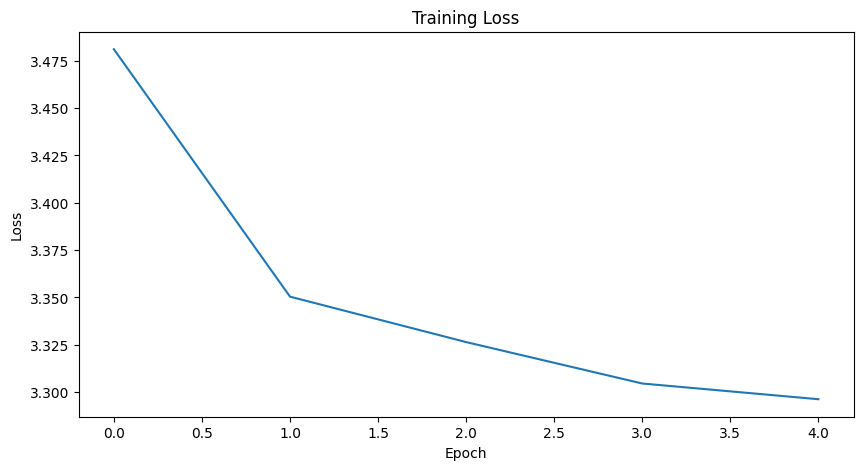

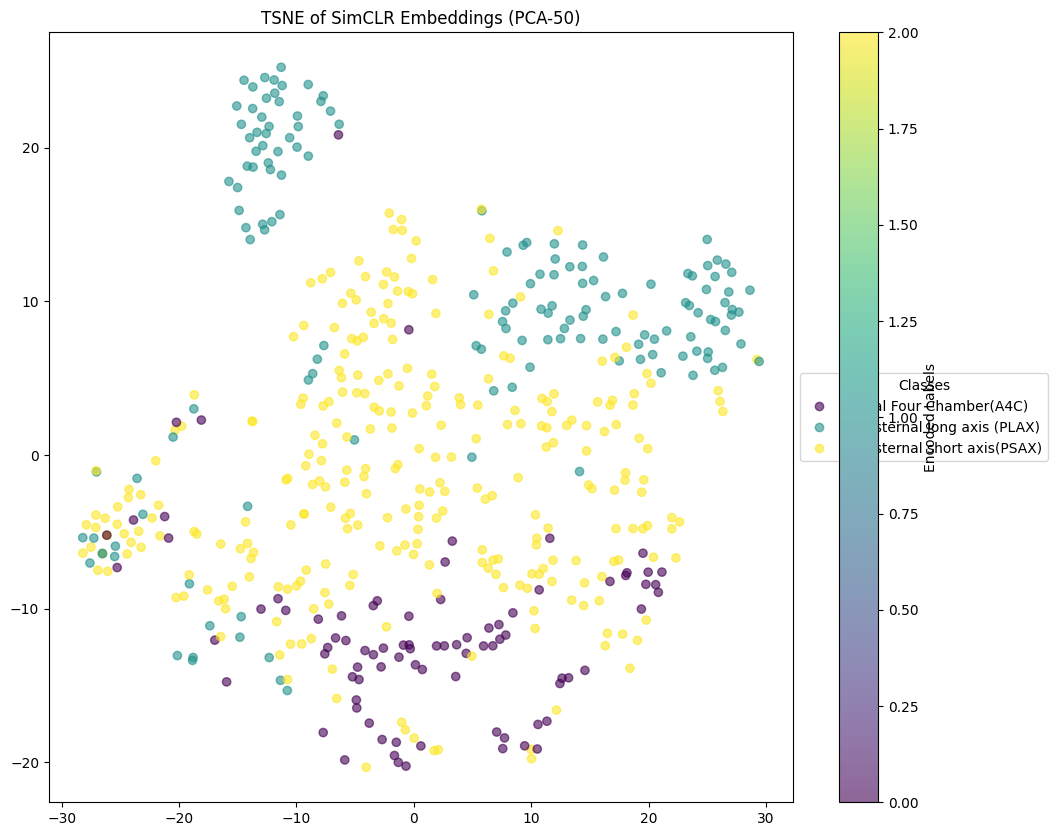

/home/lornamugambik/anaconda3/envs/venv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


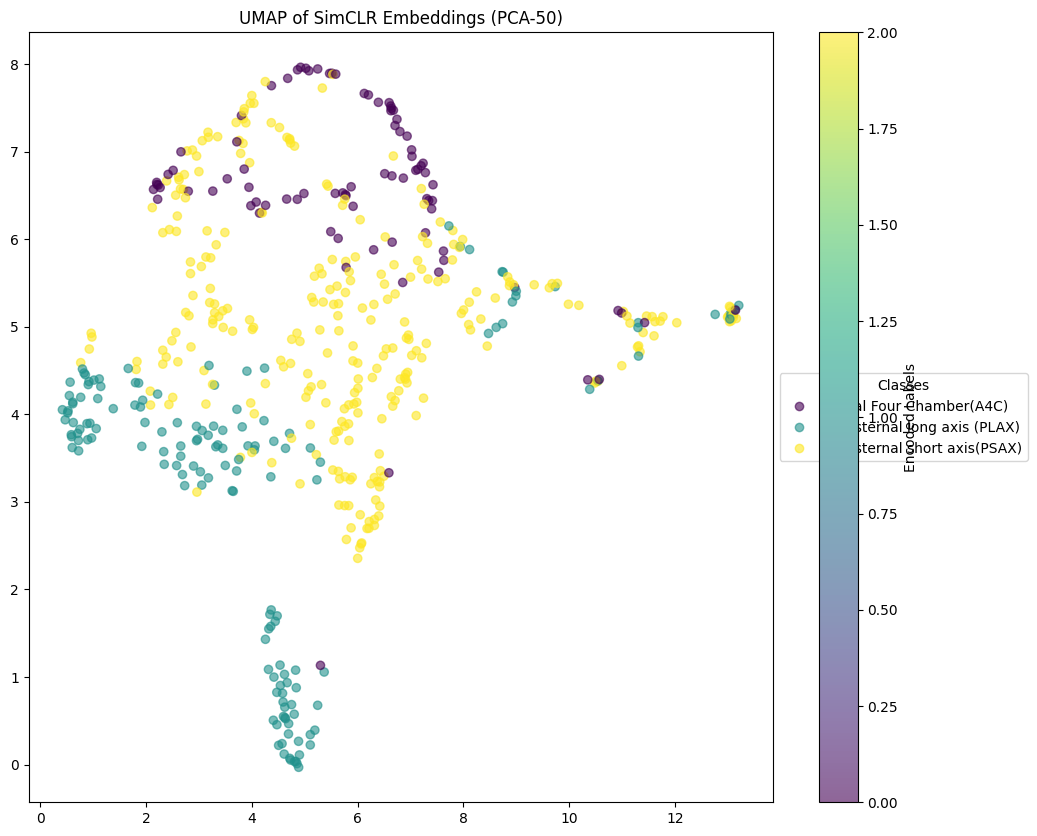

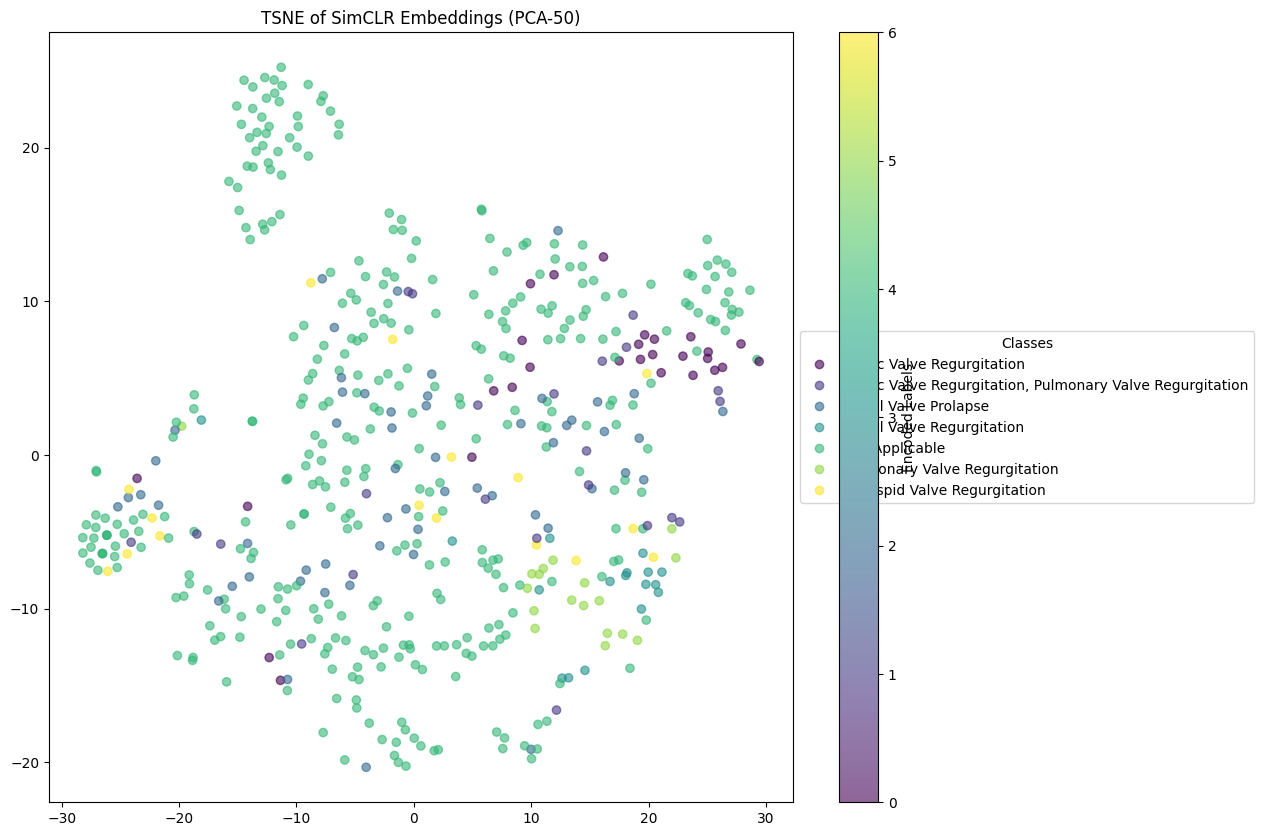

/home/lornamugambik/anaconda3/envs/venv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


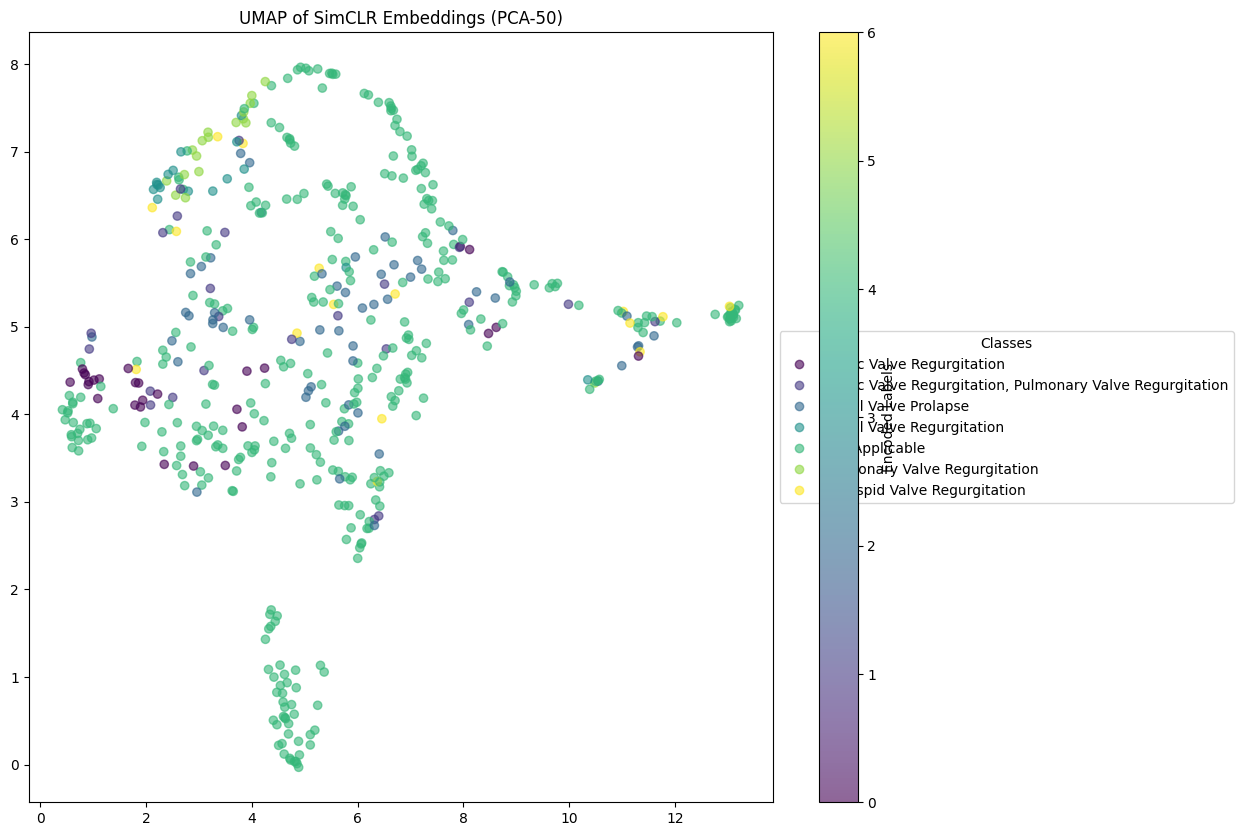

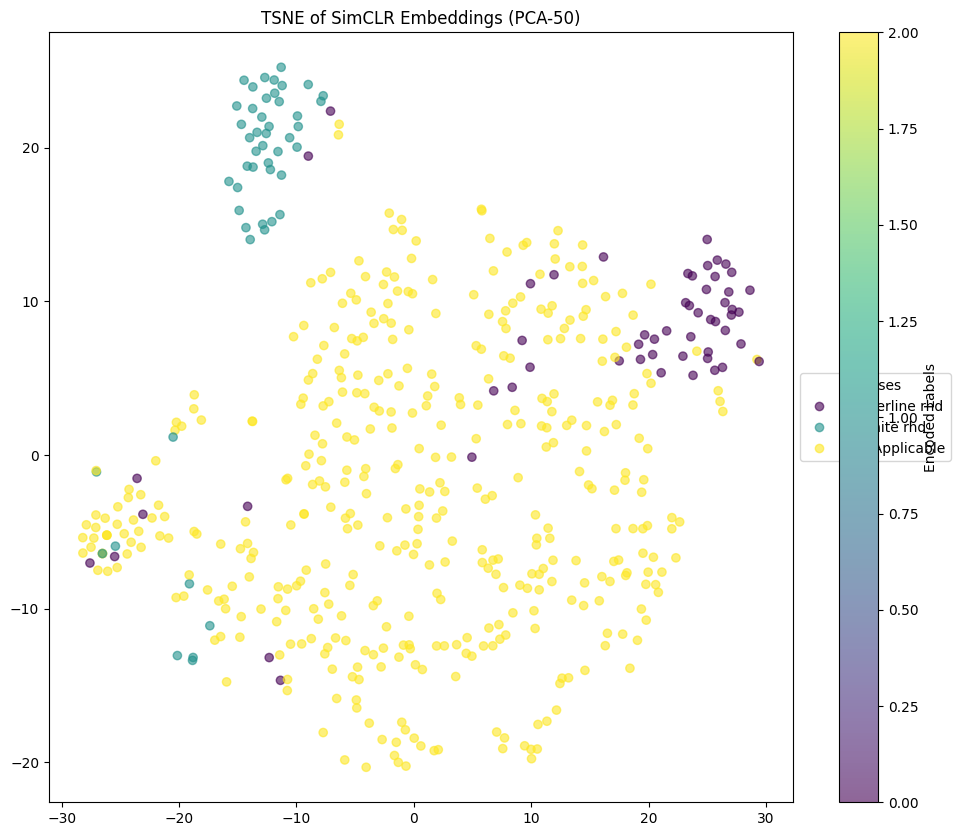

/home/lornamugambik/anaconda3/envs/venv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


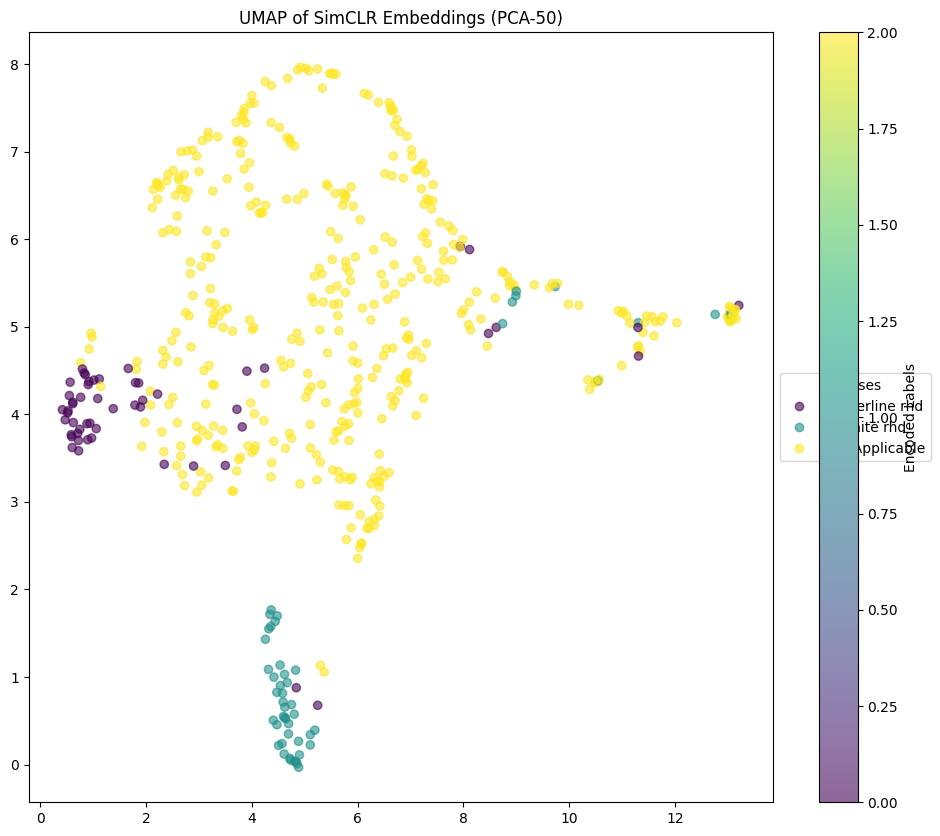

Cumulative explained variance ratio with 50 PCA components: 0.9976


In [43]:
from sklearn.preprocessing import LabelEncoder

# Visualizations
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('training_loss.png')
plt.show()

# Get embeddings for visualization
simclr.eval()
embeddings = []
labels = []

with torch.no_grad():
    for x_i, x_j, (view, condition, severity) in val_dataloader:
        images = x_i.to(device)
        h, _ = simclr(images)
        embeddings.append(h.cpu().numpy())
        labels.extend(list(zip(view, condition, severity)))

embeddings = np.concatenate(embeddings, axis=0)

# Reduce embeddings to 50 components using PCA
pca = PCA(n_components=50)
reduced_embeddings = pca.fit_transform(embeddings)

# Visualization function
def visualize_embeddings(embeddings, labels, method, filename):
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    elif method == 'umap':
        reducer = umap.UMAP(random_state=42)
    else:
        raise ValueError("Method should be either 'tsne' or 'umap'")
    
    reduced_embeddings = reducer.fit_transform(embeddings)
    
    # Encode labels
    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels)
    
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], 
                          c=encoded_labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Encoded Labels')
    plt.title(f'{method.upper()} of SimCLR Embeddings (PCA-50)')
    
    # Add a legend
    handles, _ = scatter.legend_elements()
    legend_labels = le.classes_
    plt.legend(handles, legend_labels, title="Classes", loc="center left", bbox_to_anchor=(1, 0.5))
    
    plt.savefig(filename, bbox_extra_artists=(plt.gca().get_legend(),), bbox_inches='tight')
    plt.show()

# Visualize embeddings
for i, label_type in enumerate(['view', 'condition', 'severity']):
    label_values = [label[i] for label in labels]
    visualize_embeddings(reduced_embeddings, label_values, 'tsne', f'tsne_embeddings_{label_type}_pca50.png')
    visualize_embeddings(reduced_embeddings, label_values, 'umap', f'umap_embeddings_{label_type}_pca50.png')

# Print explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
print(f"Cumulative explained variance ratio with 50 PCA components: {cumulative_variance_ratio[-1]:.4f}")

In [45]:
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluation on labeled dataset
num_classes = labelled_dataset.get_num_classes()

# Create label encoders for each label type
label_encoders = {
    'view': LabelEncoder(),
    'condition': LabelEncoder(),
    'severity': LabelEncoder()
}

for label_idx, label_type in enumerate(['view', 'condition', 'severity']):
    print(f"\nEvaluating {label_type} classification:")
    classifier = LinearClassifier(512, num_classes[label_type]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=0.001)

    # Fit label encoder on all labels
    all_labels = []
    for x_i, x_j, labels in train_dataloader:
        all_labels.extend(labels[label_idx])
    label_encoders[label_type].fit(all_labels)

    # Training the linear classifier
    for epoch in range(50):
        classifier.train()
        epoch_loss = 0
        for x_i, x_j, labels in train_dataloader:
            images = x_i.to(device)

            # Convert labels to numerical format and then to tensor
            label = label_encoders[label_type].transform(labels[label_idx])
            label = torch.tensor(label, dtype=torch.long).to(device)

            with torch.no_grad():
                features, _ = simclr(images)

            outputs = classifier(features)
            loss = criterion(outputs, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_dataloader)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/50], Loss: {avg_loss:.4f}')

    # Evaluation
    classifier.eval()
    all_preds = []
    all_true_labels = []

    with torch.no_grad():
        for x_i, x_j, labels in val_dataloader:
            images = x_i.to(device)
            label = label_encoders[label_type].transform(labels[label_idx])
            label = torch.tensor(label, dtype=torch.long).to(device)

            features, _ = simclr(images)
            outputs = classifier(features)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_true_labels.extend(label.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_true_labels, all_preds)
    precision = precision_score(all_true_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_true_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_true_labels, all_preds, average='weighted', zero_division=0)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')


Evaluating view classification:
Epoch [10/50], Loss: 0.3625
Epoch [20/50], Loss: 0.3212
Epoch [30/50], Loss: 0.3262
Epoch [40/50], Loss: 0.2997
Epoch [50/50], Loss: 0.2992
Accuracy: 0.8864
Precision: 0.8884
Recall: 0.8864
F1 Score: 0.8864

Evaluating condition classification:
Epoch [10/50], Loss: 0.7242
Epoch [20/50], Loss: 0.6568
Epoch [30/50], Loss: 0.6010
Epoch [40/50], Loss: 0.6117
Epoch [50/50], Loss: 0.6314
Accuracy: 0.8201
Precision: 0.8283
Recall: 0.8201
F1 Score: 0.7900

Evaluating severity classification:
Epoch [10/50], Loss: 0.1428
Epoch [20/50], Loss: 0.1438
Epoch [30/50], Loss: 0.1464
Epoch [40/50], Loss: 0.1198
Epoch [50/50], Loss: 0.1242
Accuracy: 0.9489
Precision: 0.9478
Recall: 0.9489
F1 Score: 0.9469
